In [1]:
%pylab inline
import jax
import jax.numpy as np
import numpy as onp
import flax
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
parameters_raw = pd.read_hdf('dalek-2020-06-02/data/grid1_v2_log_uniform_params_16feb20_part1_train_98k.h5')
spectra_raw = onp.load('dalek-2020-06-02/data/grid1_v2_log_uniform_fluxes_16feb20_part1_train_interp_98k.npy')

In [3]:
# We'll normalize the inputs/outputs a bit
from sklearn import preprocessing

parameters_n = parameters_raw.copy()
parameters_n = onp.log10(parameters_n)
parameters_n_min = parameters_n.min(axis=0)
parameters_n_max = parameters_n.max(axis=0)
parameters_n = (parameters_n - parameters_n_min)/(parameters_n_max - parameters_n_min)
parameters_n = parameters_n.values

scaler_parameters = preprocessing.StandardScaler().fit(parameters_n)
n_parameters_n = scaler_parameters.transform(parameters_n)

spectra_n = (spectra_raw - spectra_raw.min())
spectra_n = spectra_n/spectra_n.max()

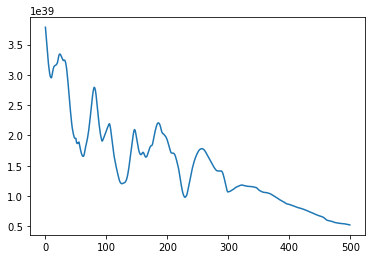

In [4]:
plot(spectra_raw[1,:])

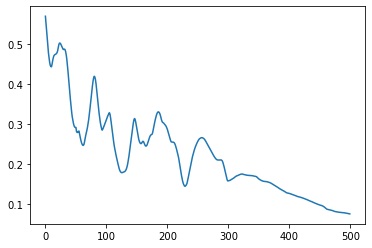

In [5]:
plot(spectra_n[1,:])

In [6]:
def deBoorVectorized(x, t, c, p):
    """
    Evaluates S(x).

    Args
    ----
    x: position
    t: array of knot positions, needs to be padded as described above
    c: array of control points
    p: degree of B-spline
    """
    k = np.digitize(x, t) -1
    
    d = [c[j + k - p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha = (x - t[j+k-p]) / (t[j+1+k-r] - t[j+k-p])
            d[j] = (1.0 - alpha) * d[j-1] + alpha * d[j]
    return d[p]

In [7]:
import flax
from flax import nn, optim
from functools import partial

class emulator(nn.Module):
    def apply(self, p, x):
        
        bs = p.shape[0]
        
        net = nn.leaky_relu(nn.Dense(p, 256))
        net = nn.leaky_relu(nn.Dense(net, 256))
                
        w = nn.Dense(net, 66)
        k = nn.Dense(net, 63)
                
        # make sure the knots sum to 1 and are in the interval 0,1
        k = np.concatenate([np.zeros((bs,1)), 
                            np.cumsum(nn.activation.softmax(k,axis=1), axis=1)],
                            axis=1)
        
        # Augment with repeating points
        ak = np.concatenate([np.zeros((bs, 3)), k, np.ones((bs,3))],axis=1)
                
        @partial(jax.vmap, in_axes=(0,0))
        def eval_spline(a, c):
            return deBoorVectorized(x, a, c, 3)
        
        return  eval_spline(ak, w)

In [8]:
x = np.linspace(0,1,500, endpoint=False)

/home/francois/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [9]:
_, initial_params = emulator.init_by_shape(jax.random.PRNGKey(0),
                                           [((1, 12), np.float32), ((500,), np.float32)])
model = flax.nn.Model(emulator, initial_params)

In [10]:
batch_size = 128

In [11]:
# Perfect, now....  let's try to learn a spline :-D 

In [12]:
def get_batch():
    """ Simple function that extracts a random batch
    """
    inds = onp.random.choice(len(n_parameters_n), batch_size)
    return {'x': n_parameters_n[inds].astype('float32'),
            'y': spectra_n[inds].astype('float32')}

In [13]:
batch = get_batch()

In [14]:
@jax.jit
def train_step(optimizer,batch):
  def loss_fn(model):
    pred_y = model(batch['x'], x)
    loss = np.sum((pred_y - batch['y'])**2,axis=1).mean() 
    return loss
  l, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer,l 

In [15]:
 # We also need an optimizer
optimizer = flax.optim.Momentum(
      learning_rate=0.001, beta=0.9).create(model)

In [16]:
losses = []

In [17]:
batch = get_batch()

In [33]:
for i in range(10000):
    # Let's try to learn
    batch = get_batch()
    optimizer, l = train_step(optimizer, batch)
    losses.append(l)
    if i%1000 ==0:
        print(l)

0.030056085
0.028190175
0.026994
0.02775383
0.027639898
0.027010098
0.02612537
0.027091142
0.026138822
0.022351477


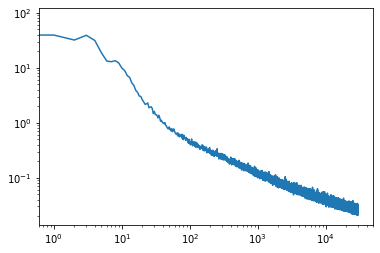

In [34]:
loglog(losses)

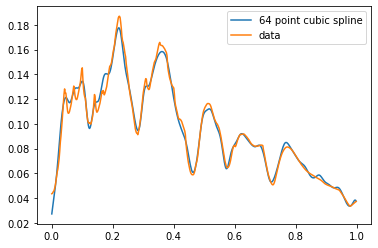

In [37]:
plot(x, optimizer.target(batch['x'], x)[0], label='64 point cubic spline')
plot(x, batch['y'][0], label='data')
legend()

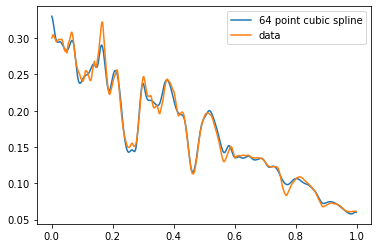

In [38]:
plot(x, optimizer.target(batch['x'], x)[1], label='64 point cubic spline')
plot(x, batch['y'][1], label='data')
legend()

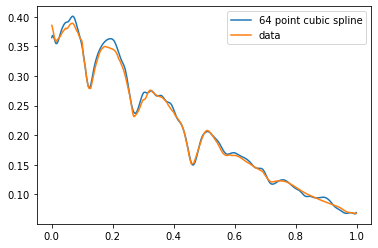

In [43]:
plot(x, optimizer.target(batch['x'], x)[6], label='64 point cubic spline')
plot(x, batch['y'][6], label='data')
legend()